<a href="https://colab.research.google.com/github/dxmai/CS114.L21.KHCL/blob/main/FinalProject/FakeNewsDetection_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import các thư viện tương ứng

In [ ]:
#Phần thống kê dữ liệu
import pandas as pd
import matplotlib.pyplot as plt

#Chia dữ liệu
from sklearn.model_selection import train_test_split

#Làm sạch dữ liệu
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize

#Vẽ biểu đồ 
import numpy as np
import seaborn as sb

#Chuyển data thành dạng ma trận số
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


#Tính thời gian
import time
from decimal import *


#Tạo và chạy model
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score, recall_score

#Lưu model thành 1 file để có thể chạy độc lập
import pickle

In [ ]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


#Thống kê dữ liệu

In [ ]:
#Fake news 
fake = pd.read_json('data_fake_news.json')
fake

,date,title,text,is_fake
0,2021-05-28 00:00:00,US Mint Delays Silver Shipments Due To “Global...,Interest in silver is soaring (both for indust...,1
1,2021-06-28 00:00:00,"Research Paper Exposes Cybersecurity, Environm...",A 2018 survey revealed did NOT want to live i...,1
2,2021-05-29 00:00:00,DeSantis’s Anti-Riot Law Undermines Two Import...,When Florida Gov. Ron DeSantis spent the last ...,1
3,2021-05-28 00:00:00,Another Massive Cargo Ship Was Just Stuck In t...,To quote the great Los Angeles sportscaster Vi...,1
4,2021-06-25 00:00:00,BofA Crashes The “Transitory” Party: Sees Up T...,"At the start of May, when observing the avalan...",1
...,...,...,...,...
231613,2021-05-25,Lisa Murkowski Comes Out In Favor Of Investiga...,she is supporting a bill to create an indepen...,1
231614,2021-05-23,Biden Cancels Trump And Reinstates LGBTQ Prote...,Maddow said this about book on‘[Del Perccio sh...,1
231615,2021-05-25,Company Helping Run AZ Election Audit Abandons...,The contract that looped the company into the...,1
231616,2021-05-20,Biden VS Trump Polling Matchup Has GOP Clutchi...,2024 National GE:Biden 48% (+12)Trump 36%,1


Link **data_fake_news.json**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/data_fake_news.json

In [ ]:
#Real news
real = pd.read_json('data_real_news.json')
real

,date,title,text,is_fake
0,2021-06-24 00:00:00,We’re hiring: a news assistant in Tokyo,"is seeking a . This is an exciting, multiface...",0
1,2021-06-24 00:00:00,An important census product may soon use synth...,"(), which is sent to around 1% of America’s p...",0
2,2021-06-24 00:00:00,Myanmar’s civil war is becoming bloodier and m...,"bicycle, wearing a -shirt emblazoned with a c...",0
3,2021-06-24 00:00:00,America’s Supreme Court is less one-sided than...,America’s Supreme Court seemed destined for a...,0
4,2021-06-12 00:00:00,The anti-graft unit of China’s Communist Party...,"June 1st Shi Zhaoqing, a local boss in China’...",0
...,...,...,...,...
253933,2018-01-01 00:00:00,Detectives: Florida man beat 6-year-old stepso...,"Jack Junior Montgomery, 31, has been charged w...",0
253934,2018-01-01 00:00:00,1 dead after shooting at New Year’s Eve party ...,Officers responded to the home near Northwest ...,0
253935,2018-01-01 00:00:00,Prosecutor: Teen held in shooting death of par...,Monmouth County Prosecutor Chris Gramiccioni s...,0
253936,2018-01-01 00:00:00,Man hospitalized due to firework injury in NW ...,"The victim, identified as 25-year-old Orlando ...",0


Link **data_real_news.json**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/data_real_news.json

In [ ]:
print("Fake news size: ", len(fake), "\nReal news size: ", len(real))

Fake news size:  231618 
Real news size:  253938


In [ ]:
dataset = real.append(fake).sample(frac=1).reset_index(drop=True)
dataset

,date,title,text,is_fake
0,2021-05-20 00:00:00,Balkan money-laundering is booming,prosecutors in North Macedonia charged Nikola...,0
1,2020-04-22 10:52:00,Netflix releases for May 2020: Everything comi...,", which is a new comedy series starring Steve ...",0
2,2020-03-24 00:00:00,Prepping with kids: What to teach them about n...,") As a prepper, you may have at least the very...",1
3,2020-04-04 00:00:00,Prince Harry and Meghan Markle Call Out the Qu...,The Duke and Duchess of Sussex posted what see...,1
4,2021-06-08 00:00:00,Michael Pento: The Fed’s Tools Are Broken,The U.S. central bank has metastasized from an...,1
...,...,...,...,...
485551,2019-09-17 10:53:00,Wendy Williams Rocks Her Own Merch While Showi...,went all out with her new look walking the str...,0
485552,2020-10-02 21:11:00,Montgomery Co. health officials advise day car...,.Montgomery County Health Officer Dr. Travis G...,0
485553,"July 10, 2020 09:12 PM","Coronavirus Survivor, 32, Leaves Hospital Afte...",After nearly 100 days in the hospital battling...,0
485554,2019-05-07 00:00:00,Bank of Canada’s Plan to Enslave you – The Jas...,In this video John Sneisen and Financial Advis...,1


##Thống kê theo số lượng thật giả

([<matplotlib.patches.Wedge at 0x7f2bed3c1350>,
 [Text(1.0971336860234244, 0.07935789181079546, 'Fake'),
  Text(-1.0971336860234244, -0.0793578918107955, 'Real')],
 [Text(0.5984365560127769, 0.04328612280588843, '47.7%'),
  Text(-0.5984365560127769, -0.04328612280588845, '52.3%')])

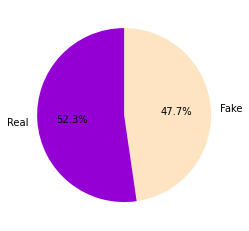

In [ ]:
size = [len(fake['is_fake']), len(real['is_fake'])]
colors = ['bisque', 'darkviolet']
plt.pie(size, labels=['Fake', 'Real'], colors=colors, autopct='%1.1f%%', startangle=90,counterclock=False)

##Thống kê theo số lượng từ trong **text**

In [ ]:
len_sentence = dataset['text']
seq_len = [len(i.split()) for i in len_sentence]
#Hàm đếm số lượng từ và phân loại
len_sen = {}
for item in seq_len:
  if item not in len_sen.keys():
    len_sen[item] = 1
  else:
    len_sen[item] += 1

Text(0.5, 1.0, 'Numbers of words in text')

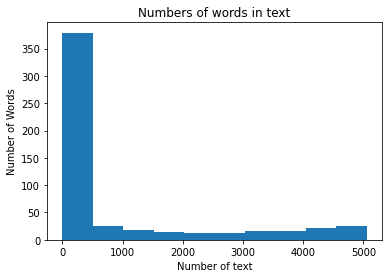

In [ ]:
plt.hist(len_sen.values())
plt.ylabel('Number of Words')
plt.xlabel('Number of text')
plt.title('Numbers of words in text')

##Theo năm bài báo được đăng

In [ ]:
#Hàm đếm số lượng mỗi bài báo trong những năm được cho phép <=> 3 năm trở lại <=> 2021, 2020, 2019, 2018
dictionary = {
    '2021': 0,
    '2020': 0,
    '2019': 0,
    '2018': 0
}
for row in range(len(dataset)):
  for key in dictionary.keys():
    if key in dataset.iloc[row]['date']:
      dictionary[key] += 1

([<matplotlib.patches.Wedge at 0x7f98590fefd0>,
 [Text(0.6047465786071093, 0.9188479611246877, '2021'),
  Text(0.9149041635938293, -0.6106966279902613, '2020'),
  Text(-0.8226741720113389, -0.7302103852352815, '2019'),
  Text(-0.73553371972063, 0.817918178764804, '2018')],
 [Text(0.3298617701493323, 0.5011897969771023, '18.5%'),
  Text(0.4990386346875432, -0.3331072516310516, '31.7%'),
  Text(-0.4487313665516393, -0.39829657376469896, '26.5%'),
  Text(-0.4012002107567072, 0.4461371884171658, '23.3%')])

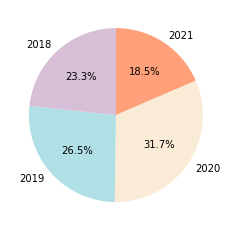

In [ ]:
size = dictionary.values()
colors = ['lightsalmon', 'antiquewhite', 'powderblue', 'thistle']
plt.pie(size, labels=['2021', '2020', '2019', '2018'], colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)

#Split data

In [ ]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print("Train size: ", len(train))
train.head()

Train size:  388444


,date,title,text,is_fake
0,2020-06-11 00:00:00,India avoids junk status,"leaky, India’s lockdown became “localised” th...",0
1,2018-10-19 00:00:00,Dr. Doom’s latest warning should not go unheeded,:Dr. Doom is back—and age has done nothing to ...,1
2,"Updated: May 16, 2020 3:46:32 pm",Explained: A new species discovered on Twitter...,"Ana Sofia Reboleira, biologist and associate p...",0
3,2018,15 Plants & Herbs That Can Boost Lung Health,Safety is one of the most critical areas of re...,1
4,2021-06-15 00:00:00,Sheryl Crow Reveals She Was Sexually Harassed ...,The singer Sheryl Crow is opening up this week...,1


Link **train.json**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/train.json

In [ ]:
print("Test size: ", len(test))
test.head()

Test size:  97112


,date,title,text,is_fake
0,"February 5, 2018",Battle Over Self-Driving Cars Goes To Court In...,"Waymo alleges that in early 2016, Anthony Leva...",0
1,2018-12-14 00:00:00,"The Market’s Entering a Transitional Period, S...",by Oppenheimer’s Ari Wald says we’ve now broke...,1
2,2021-01-16 23:35:00,Australian Open arrivals hit by 4 COVID-19 pos...,Health authorities confirmed there’d been thre...,0
3,2019-05-16 00:00:00,A 200km loop around Paris,ground beneath the western Paris business dis...,0
4,2018-07-09 00:00:00,Meet Dominic Raab: the new Brexit boss,"AT FIRST glance, the new man with the task of ...",0


Link **test.json**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/test.json

#Cleaning data

##Loại bỏ những yếu tố không cần thiết

In [ ]:
#Loại bỏ những cột không cần dùng đến
train = train.drop(["date"],axis=1)
train = train.drop(["title"],axis=1)
train

,text,is_fake
0,"leaky, India’s lockdown became “localised” th...",0
1,:Dr. Doom is back—and age has done nothing to ...,1
2,"Ana Sofia Reboleira, biologist and associate p...",0
3,Safety is one of the most critical areas of re...,1
4,The singer Sheryl Crow is opening up this week...,1
...,...,...
388439,During this week’s presidential debate Gabbard...,1
388440,) In a letter to the Seattle City Council – wh...,1
388441,", born in 1886 and who later passed away in 19...",1
388442,Very disappointing to say the least,1


In [ ]:
#Chuyển về kiểu chữ thường
train['text'] = train['text'].apply(lambda x: x.lower())
train.head()

,text,is_fake
0,"leaky, india’s lockdown became “localised” th...",0
1,:dr. doom is back—and age has done nothing to ...,1
2,"ana sofia reboleira, biologist and associate p...",0
3,safety is one of the most critical areas of re...,1
4,the singer sheryl crow is opening up this week...,1


In [ ]:
# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [ ]:
train['text'] = train['text'].apply(punctuation_removal)

In [ ]:
train.head()

,text,is_fake
0,leaky india’s lockdown became “localised” thi...,0
1,dr doom is back—and age has done nothing to so...,1
2,ana sofia reboleira biologist and associate pr...,0
3,safety is one of the most critical areas of re...,1
4,the singer sheryl crow is opening up this week...,1


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train.head()

,text,is_fake
0,leaky india’s lockdown became “localised” week...,0
1,dr doom back—and age done nothing soften views...,1
2,ana sofia reboleira biologist associate profes...,0
3,safety one critical areas review amongst herbs...,1
4,singer sheryl crow opening week sexual harassm...,1


In [ ]:
from google.colab import files
train.to_json('train.json', orient='records')
files.download('train.json')

##Những từ thường xuất hiện

In [ ]:
sw = set(STOPWORDS)
sw.update(["drink", "now", "wine", "flavor", "flavors"])

In [ ]:
real = train.loc[(train.is_fake == 0)]

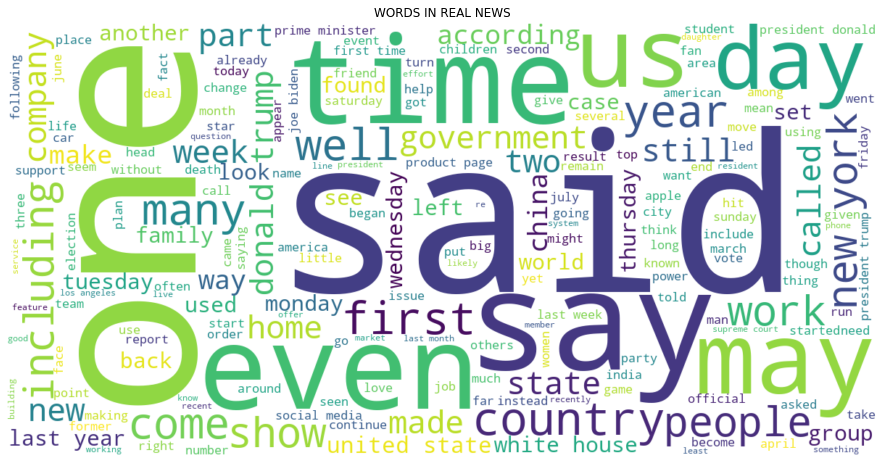

In [ ]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(real.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN REAL NEWS")
plt.axis("off")
plt.show()

In [ ]:
fake = train.loc[(train.is_fake == 1)]

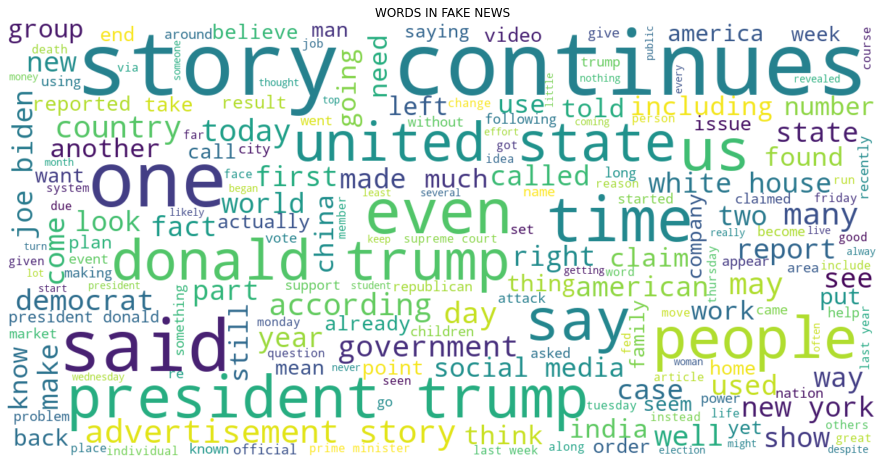

In [ ]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(fake.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN FAKE NEWS")
plt.axis("off")
plt.show()

In [ ]:
token_space = tokenize.WhitespaceTokenizer()
all_words = ' '.join([text for text in real.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

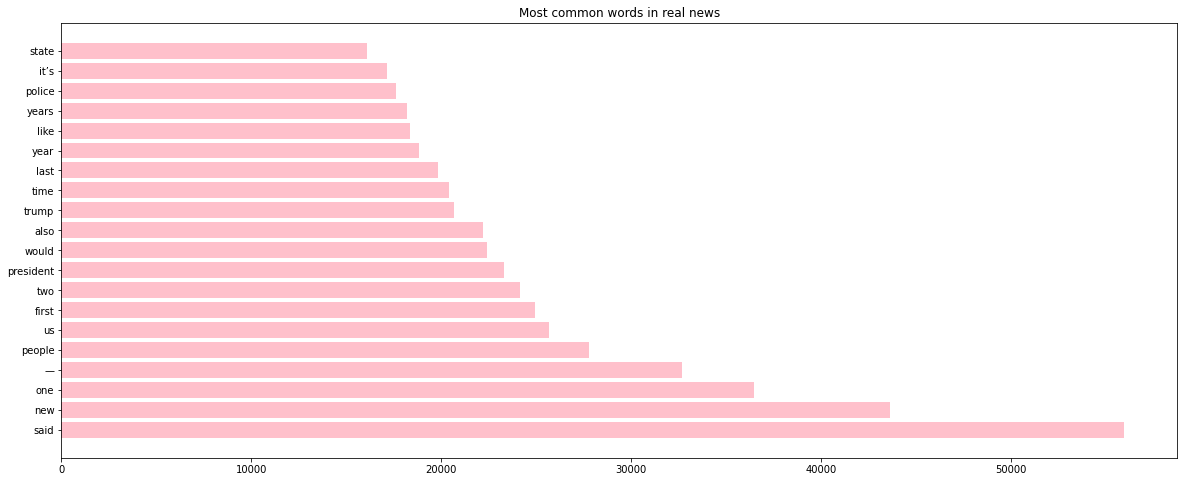

In [ ]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in real news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

In [ ]:
all_words = ' '.join([text for text in fake.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

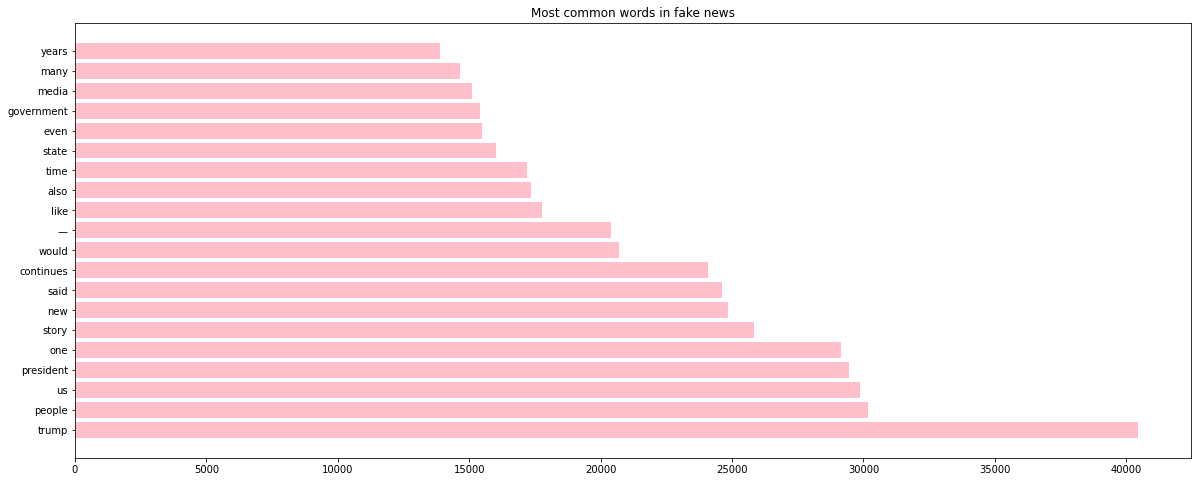

In [ ]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in fake news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

#Chạy model

In [ ]:
#Loại bỏ những cột không cần thiết trong test
test = test.drop(["date"],axis=1)
test = test.drop(["title"],axis=1)
test

,text,is_fake
0,Orlando Police provided pictures of the massiv...,0
1,In a major setback for the UPA stalwart and th...,1
2,Jeffrey Epstein’s alleged victims expressed an...,0
3,They are also not allowed to carry uniformly s...,1
4,Manuka oil is a shining example. Reports of he...,1
...,...,...
97107,", 22, sure is innovative! The mogul launched ...",0
97108,byChris Powellof the(),1
97109,A nurse and a dedicated Disney fan has died af...,0
97110,Iran being blamed. Shit just got real.,1


In [ ]:
#Quan sát lại bộ dữ liệu 1 lần nữa
def data_obs():
    print("Training dataset size:")
    print(train.shape)
    print(train.head(10))

    print("Testing dataset size:")
    print(test.shape)
    print(test.head(10)) 


In [ ]:
data_obs()

Training dataset size:
(388444, 2)
                                                text  is_fake
0  starts 151 originally 188 slip bed new set sof...        0
1  one quite sure “real polls” asked voters cance...        1
2  soundly defeated richard spencer live debate t...        1
3  thursday facebook announced new partnership at...        1
4  official xinhua news agency said saturday land...        0
5  séverine autesserre five years wars cost 10trn...        0
6  mike posner finished cooler singer 33 shared b...        0
7  who’s bosseverything stopped afternoon preside...        1
8  trump went quite twitter rampage tuesday morni...        1
9  incident took place wednesday evening 720 pm d...        1
Testing dataset size:
(97112, 2)
                                                text  is_fake
0  Orlando Police provided pictures of the massiv...        0
1  In a major setback for the UPA stalwart and th...        1
2  Jeffrey Epstein’s alleged victims expressed an...        0
3 

[Text(0.5, 1.0, 'Distribution in train')]

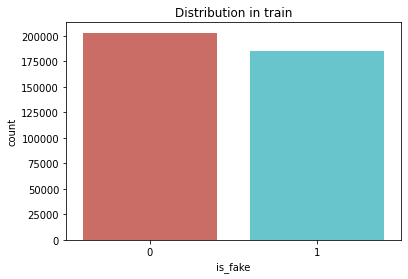

In [ ]:
#Create classes distribution 
sb.countplot(x='is_fake', data=train, palette='hls').set(title = "Distribution in train")

[Text(0.5, 1.0, 'Distribution in test')]

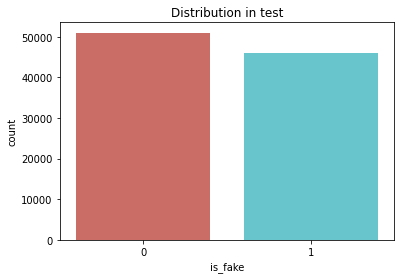

In [ ]:
sb.countplot(x='is_fake', data=test, palette='hls').set(title = "Distribution in test")

##CountVectorize (Bag of words)

In [ ]:
#Chuyển đổi dữ liệu train
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(train['text'])

In [ ]:
train_data.shape

(388444, 471456)

In [ ]:
#Chuyển đối dữ liệu test
test_data = vectorizer.transform(test['text'])

In [ ]:
getcontext().prec = 5

In [ ]:
#Hàm chuyển đổi thời gian về dạng phút để tiện quan sát
def ConvertTime(time):
  return time // 60, time % 60

###Logistic regression

Training Time =  206.26 seconds
About 3 mins and 26.26 seconds
Testing Time =  0.046012 seconds
Accuracy score ~ 77.8
              precision    recall  f1-score   support

           0       0.87      0.68      0.76     50993
           1       0.71      0.89      0.79     46119

    accuracy                           0.78     97112
   macro avg       0.79      0.78      0.78     97112
weighted avg       0.80      0.78      0.78     97112



Text(33.0, 0.5, 'Is_fake')

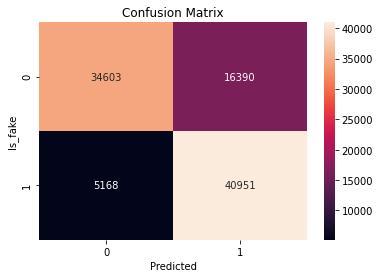

In [ ]:
#Training
startTrain_logR = time.time()
logR_clf = LogisticRegression(max_iter = 4000)
logR_clf.fit(train_data, train['is_fake'])
endTrain_logR = time.time()
print("Training Time = ", Decimal(endTrain_logR - startTrain_logR).normalize(), "seconds")
min, sec = ConvertTime(Decimal(endTrain_logR - startTrain_logR).normalize())
print("About", min, "mins and", sec, "seconds")

#Testing
startTest_logR = time.time()
predicted_logR = logR_clf.predict(test_data)
endTest_logR = time.time()
print("Testing Time = ", Decimal(endTest_logR - startTest_logR).normalize(), "seconds")

#Kết quả thu được
score = accuracy_score(test['is_fake'], predicted_logR)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_logR))

#Confusion matrix
matrix = confusion_matrix(test['is_fake'], predicted_logR)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Is_fake')

###Support Vector Machine

Training Time =  739.33 seconds
About 12 mins and 19.33 seconds
Testing Time =  0.036363 seconds
Accuracy score ~ 73.49
              precision    recall  f1-score   support

           0       0.89      0.57      0.69     50993
           1       0.66      0.92      0.77     46119

    accuracy                           0.73     97112
   macro avg       0.77      0.74      0.73     97112
weighted avg       0.78      0.73      0.73     97112



Text(33.0, 0.5, 'Is_fake')

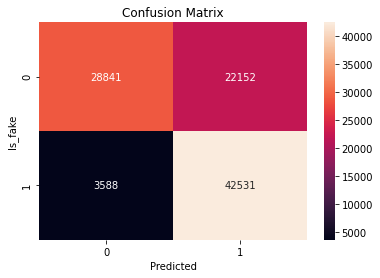

In [ ]:
#Training
startTrain_svm = time.time()
svm_clf = svm.LinearSVC(max_iter=10000)
svm_clf.fit(train_data, train['is_fake'])
endTrain_svm = time.time()
print("Training Time = ", Decimal(endTrain_svm - startTrain_svm).normalize(), "seconds")
min, sec = ConvertTime(Decimal(endTrain_svm - startTrain_svm).normalize())
print("About", min, "mins and", sec, "seconds")

#Testing
startTest_svm = time.time()
predicted_svm = svm_clf.predict(test_data)
endTest_svm = time.time()
print("Testing Time = ", Decimal(endTest_svm - startTest_svm).normalize(), "seconds")

#Kết quả thu được
score = accuracy_score(test['is_fake'], predicted_svm)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_svm))

#Confusion matrix
matrix = confusion_matrix(test['is_fake'], predicted_svm)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Is_fake')

###So sánh các giá trị

In [ ]:
compare_table = {'Accuracy score':[accuracy_score(test['is_fake'], predicted_logR), accuracy_score(test['is_fake'], predicted_svm)],
                 'F1 - score':[f1_score(test['is_fake'], predicted_logR), f1_score(test['is_fake'], predicted_svm)],
                 'Precision': [precision_score(test['is_fake'], predicted_logR), precision_score(test['is_fake'], predicted_svm)],
                 'Recall': [recall_score(test['is_fake'], predicted_logR), recall_score(test['is_fake'], predicted_svm)]
                 }

In [ ]:
table = pd.DataFrame(compare_table, index = ["Logistic Regression", "SVM"])
table

,Accuracy score,F1 - score,Precision,Recall
Logistic Regression,0.778009,0.791630,0.714166,0.887942
SVM,0.734945,0.767694,0.657530,0.922201


##Clean dataset và input để cải thiện accuracy

In [ ]:
#Chuyển về chữ thường, loại bỏ stop words,... trong test
test['text'] = test['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(punctuation_removal)  
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
test_data_clear = vectorizer.transform(test['text'])

###Logistic regression

Testing Time =  0.032025 seconds
Accuracy score ~ 86.61
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     50993
           1       0.86      0.85      0.86     46119

    accuracy                           0.87     97112
   macro avg       0.87      0.87      0.87     97112
weighted avg       0.87      0.87      0.87     97112



Text(33.0, 0.5, 'Is_fake')

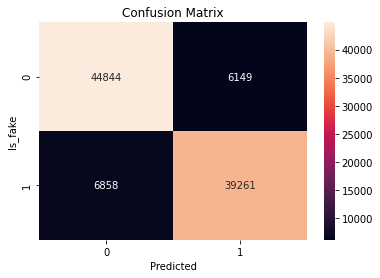

In [ ]:
#Testing
startTest = time.time()
predicted_logR_clear = logR_clf.predict(test_data_clear)
endTest = time.time()
print("Testing Time = ", Decimal(endTest - startTest).normalize(), "seconds")

#Kết quả thu được
score = accuracy_score(test['is_fake'], predicted_logR_clear)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_logR_clear))

#Confusion matrix
matrix = confusion_matrix(test['is_fake'], predicted_logR_clear)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Is_fake')

###Support Vector Machine

Testing Time =  0.029508 seconds
Accuracy score ~ 85.1
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     50993
           1       0.85      0.83      0.84     46119

    accuracy                           0.85     97112
   macro avg       0.85      0.85      0.85     97112
weighted avg       0.85      0.85      0.85     97112



Text(33.0, 0.5, 'Is_fake')

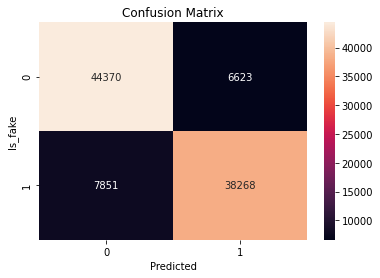

In [ ]:
#Testing
startTest = time.time()
predicted_svm_clear = svm_clf.predict(test_data_clear)
endTest = time.time()
print("Testing Time = ", Decimal(endTest - startTest).normalize(), "seconds")

#Kết quả thu được
score = accuracy_score(test['is_fake'], predicted_svm_clear)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_svm_clear))

#Confusion matrix
matrix = confusion_matrix(test['is_fake'], predicted_svm_clear)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Is_fake')

##So sánh các giá trị

In [ ]:
compare_table_clear = {'Accuracy score':[accuracy_score(test['is_fake'], predicted_logR_clear), accuracy_score(test['is_fake'], predicted_svm_clear)],
                 'F1 - score':[f1_score(test['is_fake'], predicted_logR_clear), f1_score(test['is_fake'], predicted_svm_clear)],
                 'Precision': [precision_score(test['is_fake'], predicted_logR_clear), precision_score(test['is_fake'], predicted_svm_clear)],
                 'Recall': [recall_score(test['is_fake'], predicted_logR_clear), recall_score(test['is_fake'], predicted_svm_clear)]
                 }

In [ ]:
table_clear = pd.DataFrame(compare_table_clear, index = ["Logistic Regression", "SVM"])
table_clear

,Accuracy score,F1 - score,Precision,Recall
Logistic Regression,0.866062,0.857892,0.864589,0.851298
SVM,0.850956,0.840963,0.852465,0.829766


So sánh 2 model trước và sau khi clean bộ test

In [ ]:
logistic = {'Accuracy score':[accuracy_score(test['is_fake'], predicted_logR), accuracy_score(test['is_fake'], predicted_logR_clear)],
                 'F1 - score':[f1_score(test['is_fake'], predicted_logR), f1_score(test['is_fake'], predicted_logR_clear)],
                 'Precision': [precision_score(test['is_fake'], predicted_logR), precision_score(test['is_fake'], predicted_logR_clear)],
                 'Recall': [recall_score(test['is_fake'], predicted_logR), recall_score(test['is_fake'], predicted_logR_clear)]
                 }
svm = {'Accuracy score':[accuracy_score(test['is_fake'], predicted_svm), accuracy_score(test['is_fake'], predicted_svm_clear)],
                 'F1 - score':[f1_score(test['is_fake'], predicted_svm), f1_score(test['is_fake'], predicted_svm_clear)],
                 'Precision': [precision_score(test['is_fake'], predicted_svm), precision_score(test['is_fake'], predicted_svm_clear)],
                 'Recall': [recall_score(test['is_fake'], predicted_svm), recall_score(test['is_fake'], predicted_svm_clear)]
                 }

In [ ]:
logistic = pd.DataFrame(logistic, index = ["Before", "After"])
print("Changes after cleaning testing data - Using Logistic Regression")
logistic

Changes after cleaning testing data - Using Logistic Regression


,Accuracy score,F1 - score,Precision,Recall
Before,0.778009,0.791630,0.714166,0.887942
After,0.866062,0.857892,0.864589,0.851298


In [ ]:
svm = pd.DataFrame(svm, index = ["Before", "After"])
print("Changes after cleaning testing data - Using SVM")
svm

Changes after cleaning testing data - Using SVM


,Accuracy score,F1 - score,Precision,Recall
Before,0.734945,0.767694,0.657530,0.922201
After,0.850956,0.840963,0.852465,0.829766


**Kết luận**: Cleaning test data sẽ nhận về được accuracy cao hơn

#Phần phát triển 

Link colab phần phát triển: https://colab.research.google.com/drive/1XtwqndMjvba9Vh06fYmrgCpc6d7Mm1SP?usp=sharing

Theo kết quả của chưởng 4.2 - Phần cải tiến, trong báo cáo đồ án cuối kỳ, thì mô hình có accuracy cao nhất chính là mô dùng có tiền xử lý dữ liệu test và chạy trên LinearSVC, dùng Tf - idf kết hợp n-grams

In [ ]:
#Dùng unigram và bigram (trigram quá nhiều từ, dẫn đến colab không thể chạy nổi)
#Chuyển đổi train
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
train_data_ngram = tfidf_ngram.fit_transform(train['text'])

In [ ]:
#Sau khi dùng n-gram, số lượng từ vựng tăng 
print("Not using n-gram\n", train_data.shape)
print("Using uni and bigram\n", train_data_ngram.shape)

Not using n-gram
 (388444, 471456)
Using uni and bigram
 (388444, 7901801)


In [ ]:
test_data_ngram = tfidf_ngram.transform(test['text'])

Training Time =  31.771 seconds
About 0 mins and 31.771 seconds
Testing Time =  0.10101 seconds
Accuracy score ~ 88.68
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     50993
           1       0.90      0.85      0.88     46119

    accuracy                           0.89     97112
   macro avg       0.89      0.89      0.89     97112
weighted avg       0.89      0.89      0.89     97112



Text(33.0, 0.5, 'Is_fake')

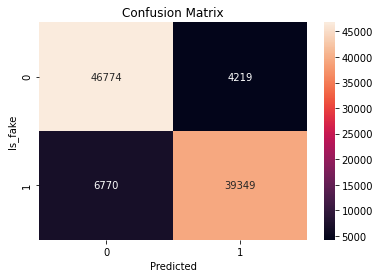

In [ ]:
#Training
startTrain_svm = time.time()
svm_clf_ngram = svm.LinearSVC(max_iter=10000)
svm_clf_ngram.fit(train_data_ngram, train['is_fake'])
endTrain_svm = time.time()
print("Training Time = ", Decimal(endTrain_svm - startTrain_svm).normalize(), "seconds")
min, sec = ConvertTime(Decimal(endTrain_svm - startTrain_svm).normalize())
print("About", min, "mins and", sec, "seconds")

#Testing
startTest_svm = time.time()
predicted_svm_ngram = svm_clf_ngram.predict(test_data_ngram)
endTest_svm = time.time()
print("Testing Time = ", Decimal(endTest_svm - startTest_svm).normalize(), "seconds")

#Kết quả thu được
score = accuracy_score(test['is_fake'], predicted_svm_ngram)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_svm_ngram))

#Confusion matrix
matrix = confusion_matrix(test['is_fake'], predicted_svm_ngram)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Is_fake')

In [ ]:
model_file = 'model.sav'
pickle.dump(svm_clf_ngram,open(model_file,'wb'))

Link **model.sav**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/model.sav

In [ ]:
tf_idf = 'tf-idf.sav'
pickle.dump(tfidf_ngram ,open(tf_idf,'wb'))

Link **tf-idf.sav**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/tf-idf.sav

#Source code phần ứng dụng

In [ ]:
import pickle
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from tkinter import *
import pygame


def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str


def RemoveStopwords(text):
    nltk.download('stopwords')
    stop = stopwords.words('english')
    words = text.split()
    clean_str = ''
    for word in words:
        if word in stop:
            continue
        clean_str += word
    return clean_str


def Clean_Data(text):
    text = text.lower()
    text = punctuation_removal(text)
    text = RemoveStopwords(text)
    return text


def CreateResultWindow():
    result = Tk()
    result.geometry('300x100+200+100')
    result.title("Result!!!")
    tfidf_ngram = pickle.load(open('tf-idf.sav', 'rb'))
    text_to_check = inputText.get("1.0", END)
    text_to_check = Clean_Data(text_to_check)
    text_to_check = tfidf_ngram.transform([text_to_check])
    load_model = pickle.load(open('model.sav', 'rb'))
    prediction = load_model.predict(text_to_check)
    ans = "Fake" if prediction[0] == 1 else "Real"
    Label(result, text='Beep...Bop.....The text is predicted as a ' + ans + ' new').pack()
    Label(result, text='Thanks for using this!!!\n=))))', justify=CENTER).pack()
    inputText.delete('1.0', END)
    result.mainloop()


pygame.mixer.init()
pygame.mixer.music.load("bgm.mp3")
pygame.mixer.music.play(loops=0)
app = Tk()
app.title("Is This Fake?")
app.geometry('640x480+100+100')
instruction = "1. Paste the text you want to check\n2. Press the \"Check\" button\n3. Wait a few seconds"
label = Label(app, text=instruction, justify=LEFT).pack()
inputText = Text(app)
inputText.place(x=10, y=115, height=30, width=200)
inputText.pack()
Button(app, text='Check', command=CreateResultWindow).pack()
app.mainloop()

Link source code ứng dụng **app.py**: https://github.com/dxmai/CS114.L21.KHCL/blob/main/FinalProject/app.py

Link video demo ứng dụng: https://www.youtube.com/watch?v=giCGo96i_vU&t=2s

#Nguồn tham khảo

Source code nhóm tham khảo để xây dựng đồ án tại link: https://github.com/nishitpatel01/Fake_News_Detection?fbclid=IwAR1iaiFXgM9gcbSJU7GVTTxH2V-A1eVwzCVef4u-PJT6g4nW_no07uLZ0n8